# 音樂曲風辨識

## 組員:地理四 劉玫宜、地碩二 曹宇鈞 、地碩一 林子鈞

## 簡介:

#### 本次專題使用下載Youtube工作室裡提供的Audio library作為音訊的來源，資料筆數共4200首長度不一的歌曲，共有14種樂曲風格。

#### 目標: 希望將歌曲轉換為聲波的型態輸入到神經網路中，讓電腦可以學習到不同曲風的特徵波形

## 實作方法:
### 1. 透過網路爬蟲下載audio library的json檔，得到音樂類型與音檔的url，透過url下載音樂
### 2. 利用ffmpeg與librosa套件將mp3檔案讀進jupyter notebook中
### 3. 取每首歌曲前30秒，並每首歌以3秒為間隔切割，每個分隔音檔間重疊1.5秒。則共產生84000段音樂
### 4. 使用librosa將分割好的音訊轉換為梅爾頻譜並進行短時距傅立葉轉換，這麼做是為了抽取音樂特徵值
### 5. 將資料進行one-hot encoding，資料前處理則完成

## 進度報告(70%)

1. 5/10 第一次討論:蒐集分析方法與資料、讀取檔案並轉換為陣列
2. 5/17 第二次討論:json與音樂檔案下載、抽取音樂特徵值、切割音檔、少量資料輸入模型測試
3. 5/24 輸入資料分類、修改模型參數、模型訓練

本次專題參考 https://github.com/Hguimaraes/gtzan.keras 

In [1]:
#import basic package
%matplotlib inline
%env KERAS_BACKED=tensorflow
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import librosa.display
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from ipywidgets import interact
import math

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

env: KERAS_BACKED=tensorflow


Using TensorFlow backend.


In [2]:
x, sr = librosa.load('audio_0.mp3')
print('data type：', type(x)," ",'data length：',len(x))
print('取樣率為: ',sr,'Hz')
#每秒從連續訊號中取樣多少訊號

data type： <class 'numpy.ndarray'>   data length： 3473686
取樣率為:  22050 Hz


In [3]:
xshape = x.shape[0]
chunk = x[:660000]

In [4]:
def box(x=0):
    X = np.arange(0,671000,16500)
    y = [1,-1]
    plt.figure(figsize=(16,8))
    plt.plot(chunk)
    plt.plot([X[x],X[x]] ,y,c='r')
    plt.plot([X[x+1],X[x+1]] ,y,c='r')
    
jump = range(0,40)
interact(box,x=jump)    



interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.box(x=0)>

## 獲取Mel Spectrogram 特徵

參考:https://blog.csdn.net/zzc15806/article/details/79603994?fbclid=IwAR0ScgZXLXhzKHQlcsNC5dK0VJfakdj6Sv2QfNUahR_oLpKG-nW4B_Haazs

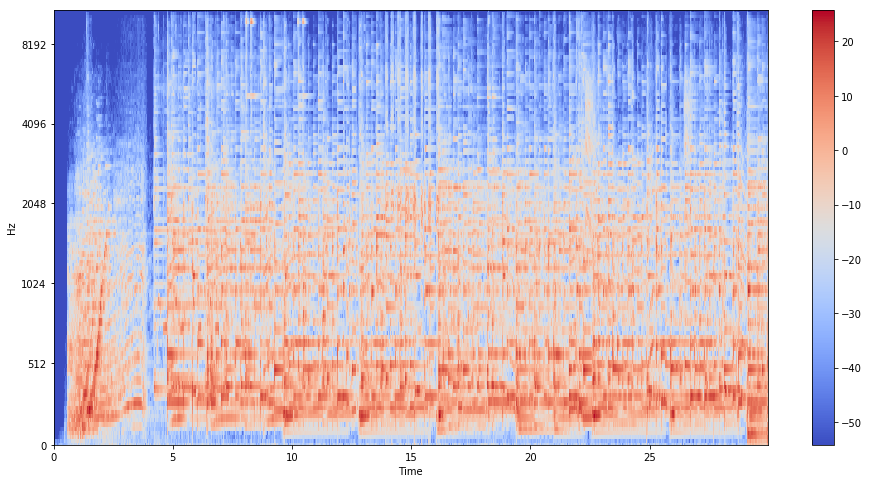

In [15]:
melspec = librosa.feature.melspectrogram(chunk, sr, n_fft=1024, hop_length=512, n_mels=128)
logmelspec = librosa.power_to_db(melspec)
plt.figure(figsize=(16,8))
librosa.display.specshow(logmelspec, x_axis='time', y_axis='mel')
plt.colorbar()

## 參考github上的function

### 將每首歌進行分割，產生新的音樂資料

In [6]:
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

### 獲得特徵值

In [7]:
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

### 讀取檔案

In [8]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

#### 由前面讀檔可知，本樂曲檔案取樣率為22050Hz/s，因此30秒的樂曲則有30*22050=661500Hz
#### 因此設定每首歌的長度 660000Hz 讀入
* 這裡讀入4種風格的歌各4首來train train看

In [9]:
gtzan_dir = 'genre/'
song_samples = 660000
genres = {'blues': 0, 'country': 1, 'classical': 2, 'jazz': 3}

X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)

np.save('x_gtzan_npy.npy', X) #music strongth
np.save('y_gtzan_npy.npy', y) #music class 

# One hot encoding of the labels
y = to_categorical(y)

(212, 128, 129, 1) (92, 128, 129, 1) (212, 4) (92, 4)


<BarContainer object of 4 artists>

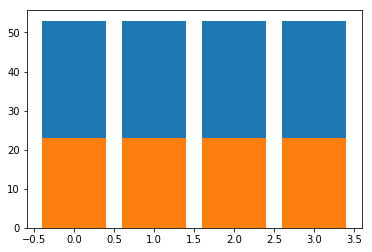

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)

In [11]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 4

model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(Dropout(0.25))

# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)  

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

Instructions for updating:
Use tf.cast instead.
Train on 212 samples, validate on 92 samples
Epoch 1/30
212/212 [==============================] - 7s 33ms/step - loss: 8.3680 - acc: 0.1981 - val_loss: 3.0740 - val_acc: 0.3261
Epoch 2/30
212/212 [==============================] - 4s 17ms/step - loss: 3.9941 - acc: 0.3821 - val_loss: 1.1520 - val_acc: 0.4891
Epoch 3/30
212/212 [==============================] - 3s 16ms/step - loss: 2.3739 - acc: 0.3726 - val_loss: 1.1692 - val_acc: 0.4674
Epoch 4/30
212/212 [==============================] - 3s 16ms/step - loss: 1.6280 - acc: 0.4104 - val_loss: 1.0926 - val_acc: 0.6087
Epoch 5/30
212/212 [==============================] - 4s 17ms/step - loss: 1.4236 - acc: 0.4198 - val_loss: 1.0998 - val_acc: 0.6304
Epoch 6/30
212/212 [==============================] - 3s 16ms/step - loss: 1.0811 - acc: 0.4953 - val_loss: 1.0910 - val_acc: 0.6739
Epoch 7/30
212/212 [==============================] - 4s 17ms/step - loss: 1.1336 - acc: 0.4953 - val_loss: 1

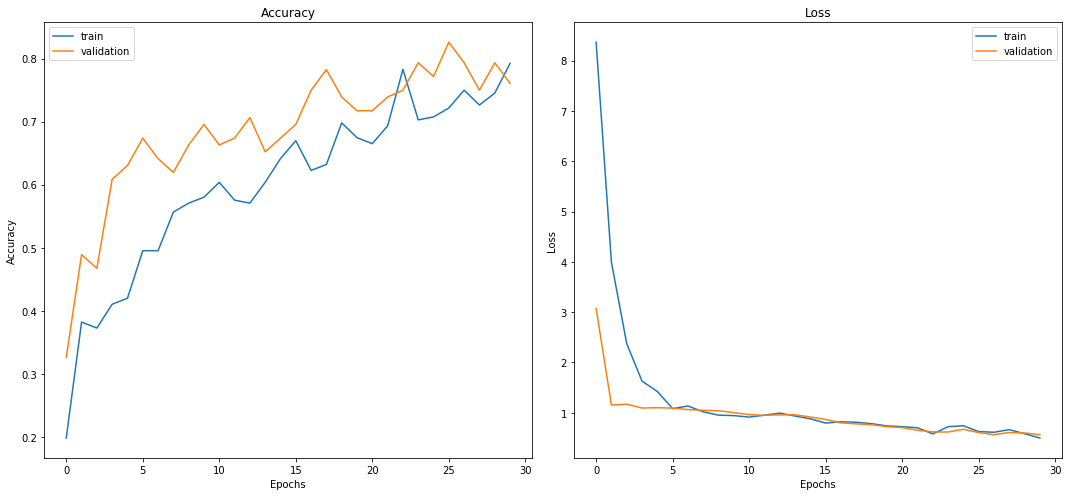

In [13]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

Normalized confusion matrix


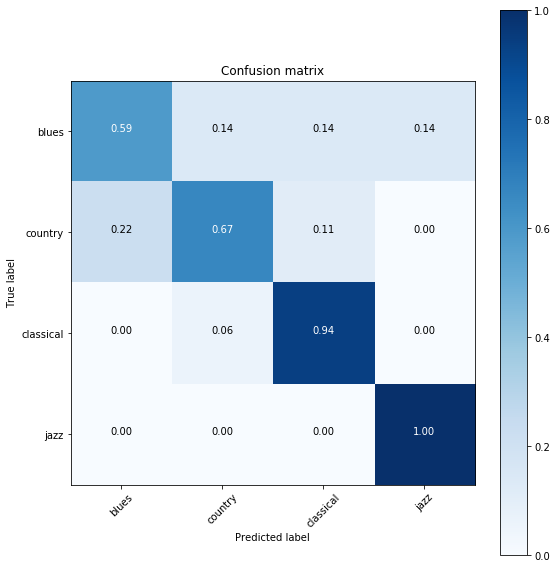

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)